# Face Verification Application for Offline Exams
## Final year project by Team 29D

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Force TensorFlow v1 (on Google Colab)

#%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)

2.1.0


In [3]:
!pip install mtcnn

  Using cached https://files.pythonhosted.org/packages/09/d1/2a4269e387edb97484157b872fa8a1953b53dcafbe4842a1967f549ac5ea/mtcnn-0.1.1-py3-none-any.whl


In [5]:
#!pip install 'h5py<3.0.0'

The system cannot find the file specified.


In [6]:
#!pip uninstall h5py
#!pip install h5py==2.10.0

  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\91891\\anaconda3\\lib\\site-packages\\~5py\\defs.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [7]:
# Import required packages
import keras
import os
import numpy as np
import cv2

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model,model_from_json

Using TensorFlow backend.


In [9]:
# Load pretrained Inception-ResNet-v1 model
# Update model and weights path according to your working environment

model_path = "Models/Inception_ResNet_v1.json"
weights_path = "Models/facenet_keras_weights.h5"

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
enc_model = model_from_json(loaded_model_json)
enc_model.load_weights(weights_path)

In [10]:
# Initialize a MTCNN face detector

mtcnn_detector = MTCNN()

In [11]:
# Function to detect and extract face from a image

def detect_face(filename, required_size=(160, 160),normalize = True):

    img = Image.open(filename)

    # convert to RGB
    img = img.convert('RGB')
 
    # convert to array
    pixels = np.asarray(img)
 
    # detect faces in the image
    results = mtcnn_detector.detect_faces(pixels)
 
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face = pixels[y1:y2, x1:x2]
  
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
 
    if normalize == True:

        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        return (face_array - mean) / std

    else : 
        return face_array

In [12]:
# Compute Face encodings and load IDs of known persons
# Update face database path according to your working environment

known_faces_encodings = []
known_faces_ids = []

known_faces_path = "Face_database/"

for filename in os.listdir(known_faces_path):
  if '.ipynb' not in filename:
    # Detect faces
    face = detect_face(known_faces_path+filename,normalize = True)

    # Compute face encodings

    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings.append(feature_vector)

    # Save Person IDs
    label = filename.split('.')[0]
    known_faces_ids.append(label)


known_faces_encodings = np.array(known_faces_encodings).reshape(len(known_faces_encodings),128)
known_faces_ids = np.array(known_faces_ids)

In [14]:
# No. of known IDs loaded from database

print(known_faces_ids.shape[0])

1


In [15]:
# Function to recognize a face (if it is in known_faces)

def recognize(img,known_faces_encodings,known_faces_ids,threshold = 0.75):

  scores = np.zeros((len(known_faces_ids),1),dtype=float)

  enc = enc_model.predict(img.reshape(1,160,160,3))
  enc/= np.sqrt(np.sum(enc**2))

  scores = np.sqrt(np.sum((enc-known_faces_encodings)**2,axis=1))

  match = np.argmin(scores)

  if scores[match] > threshold :

    return ("UNKNOWN:{}".format(scores[match]),0)
      
  else :

    return (known_faces_ids[match],scores[match])

In [18]:
# Function to perform real-time face recognition through a webcam
import cv2
def face_recognition(mode,file_path,known_faces_encodings,known_faces_ids,
                         detector = 'haar', threshold = 0.75):

  if detector == 'haar':

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('Models/haarcascade_frontalface_default.xml')

  if mode == 'webcam':

    # To capture webcam feed. Change argument for differnt webcams
    cap = cv2.VideoCapture(0)

  elif mode == 'video':
    # To capture video feed 
    cap = cv2.VideoCapture('test.mp4')
    #cap = open('/content/drive/MyDrive/Inception_Face_Recognition_using_Siamese_Network-master/test.mp4','rb').read()
    
  while True:

    # Read the frame
    _, img = cap.read()
    
    # Stop if end of video file
    if _ == False:
        print('false')
        break;

    if detector == 'haar':
    
      #Convert to grayscale
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Detect the faces
      faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    elif detector == 'mtcnn' :  

      results = mtcnn_detector.detect_faces(img)
      
      if(len(results)==0):
        continue

      faces = []
    
      for i in range(len(results)):
        
        x,y,w,h = results[i]['box']
        x, y = abs(x), abs(y)
        faces.append([x,y,w,h])

    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        
        image = Image.fromarray(img[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized,known_faces_encodings,known_faces_ids,threshold = 0.75)
        
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    # Display
    cv2.imshow(img)
    
    # Stop if escape key is pressed
    key = cv2.waitKey(25) & 0xff
    if key==27:
        break

  # Release the VideoCapture object
  cap.release() 

In [20]:
# Execute Face recognition on a Video file.
# Note : Threshold has to be adjusted according to your requirements !

#face_recognition('video',"/test.mp4",known_faces_encodings,known_faces_ids,detector = 'mtcnn',threshold = 0.75)

false


In [21]:
import sys
import numpy as np
from matplotlib.pyplot import imread
import pickle
import os
import random
import matplotlib.pyplot as plt
import argparse
import numpy.random as rng
from random import seed
from random import randint

In [22]:
# Function to detect and extract face from a image

def detect_face1(filename, required_size=(160, 160),normalize = True):

    img = Image.open(filename)

    # convert to RGB
    img = img.convert('RGB')
 
    # convert to array
    pixels = np.asarray(img)
    image = Image.fromarray(pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    if normalize == True:

        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        return (face_array - mean) / std

    else : 
        return face_array

In [ ]:
#path = '/content/drive/MyDrive/Inception_Face_Recognition_using_Siamese_Network-master/test_data/'
#x=loadimgs1(path)

In [23]:
def trial_detection(file_path,known_faces_encodings,known_faces_ids,
                         detector = 'mtcnn', threshold = 0.75):
  face_cascade = cv2.CascadeClassifier('Models/haarcascade_frontalface_default.xml')
  fig1, axs1 = plt.subplots(1,len(os.listdir(file_path)),figsize=(20,10))
  c = 0
  fig1.tight_layout()
  axs1[c].xaxis.set_visible(False)
  axs1[c].yaxis.set_visible(False)
  for name in os.listdir(file_path):
    # Read each test image
    image_path=os.path.join(file_path,name)
    img = detect_face(image_path,normalize = False)

    if detector == 'haar':
    
      #Convert to grayscale
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Detect the faces
      faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    elif detector == 'mtcnn' :  

      results = mtcnn_detector.detect_faces(img)
      
      if(len(results)==0):
        continue

      faces = []
    
      for i in range(len(results)):
        
        x,y,w,h = results[i]['box']
        x, y = abs(x), abs(y)
        faces.append([x,y,w,h])

    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        
        image = Image.fromarray(img[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized,known_faces_encodings,known_faces_ids,threshold = 0.75)
        
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    print(label)
    # Display
    #cv2_imshow(img)
    axs1[c].xaxis.set_visible(False)
    axs1[c].yaxis.set_visible(False)
    axs1[c].imshow(face_array)
    axs1[c].set_title(label)
    c = c + 1

('UNKNOWN:1.4120092391967773', 0)


('UNKNOWN:1.4827812910079956', 0)
('Paul_Rudd', 0.47184828)


('Paul_Rudd', 0.6200687)


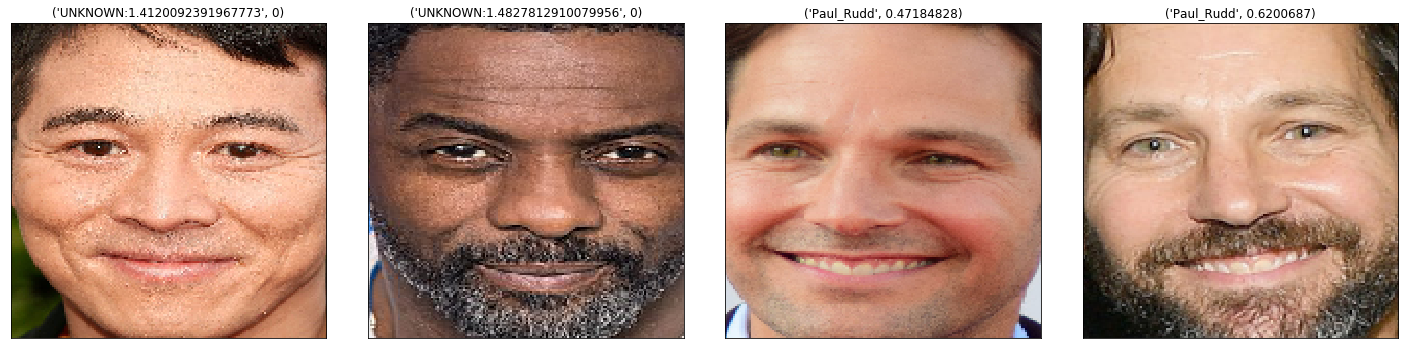

In [25]:
trial_detection('trial_set',known_faces_encodings,known_faces_ids,
                         detector = 'mtcnn', threshold = 0.75)

In [36]:
def orientation_detection(file_path,
                         detector = 'mtcnn', threshold = 0.75):
  face_cascade = cv2.CascadeClassifier('Models/haarcascade_frontalface_default.xml')
  for name in os.listdir(file_path):
    # Read each test image
    image_path=os.path.join(file_path,name)
    folder_path=os.path.join("orientation","Person-"+name.split('.')[0])
    #img = detect_face(image_path,normalize = False)
    #get encoding of support faces first
    
    known_faces_encoding = []
    known_faces_id = []

    known_faces_path = image_path

    
    if '.ipynb' not in name:
      # Detect faces
      face = detect_face(known_faces_path,normalize = True)
      face1 = detect_face(known_faces_path,normalize = False)
      # Compute face encodings

      feature_vector = enc_model.predict(face.reshape(1,160,160,3))
      feature_vector/= np.sqrt(np.sum(feature_vector**2))
      known_faces_encoding.append(feature_vector)

      # Save Person IDs
      label = name.split('.')[0]
      known_faces_id.append(label)


    known_faces_encoding = np.array(known_faces_encoding).reshape(len(known_faces_encoding),128)
    known_faces_id = np.array(known_faces_id)
    c = 0
    files = sorted(os.listdir(folder_path))
    fig, axs = plt.subplots(1,len(files)+1,figsize=(20,10))
    fig.tight_layout()
    axs[c].xaxis.set_visible(False)
    axs[c].yaxis.set_visible(False)
    axs[c].imshow(face1)
    axs[c].set_title('Support')
    for pic in files:
      pic_path=os.path.join(folder_path,pic)
      face_array = detect_face(pic_path,normalize = False)
      # Normalize
      mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
      std = np.std(face_array, axis=(0,1,2), keepdims=True)
      std_adj = np.maximum(std, 1.0)
      face_array_normalized = (face_array - mean) / std

      # Recognize
      label = recognize1(face_array_normalized,known_faces_encoding,known_faces_id,threshold)
          
      #cv2.rectangle(face_array, (x, y), (x+w, y+h), (0, 0, 0), 2)
      #cv2.putText(face_array, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
      #print(label)
      # Display
      #cv2_imshow(img)
      c = c + 1
      axs[c].xaxis.set_visible(False)
      axs[c].yaxis.set_visible(False)
      axs[c].imshow(face_array)
      axs[c].set_title(label)
      plt.imshow(face_array)

In [37]:
def recognize1(img,known_faces_encoding,known_faces_id,threshold = 0.75):

  scores = np.zeros((len(known_faces_id),1),dtype=float)

  enc = enc_model.predict(img.reshape(1,160,160,3))
  enc/= np.sqrt(np.sum(enc**2))

  scores = np.sqrt(np.sum((enc-known_faces_encoding)**2,axis=1))

  match = np.argmin(scores)

  if scores[match] > threshold :

    return ("UNKNOWN:{}".format(scores[match]),0)
      
  else :

    return ("Match",scores[match])

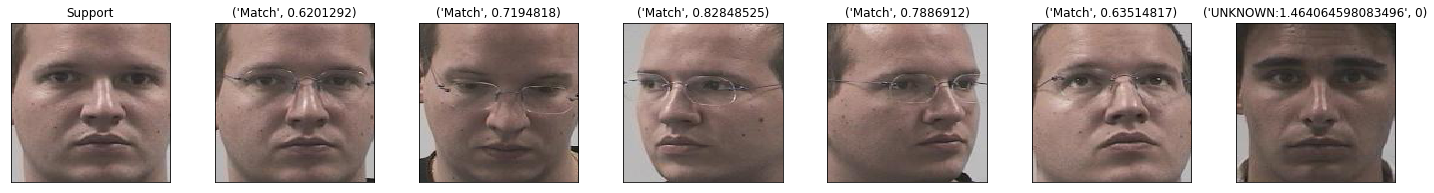

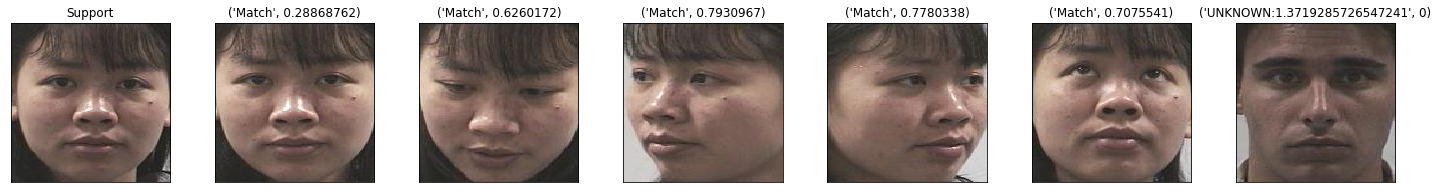

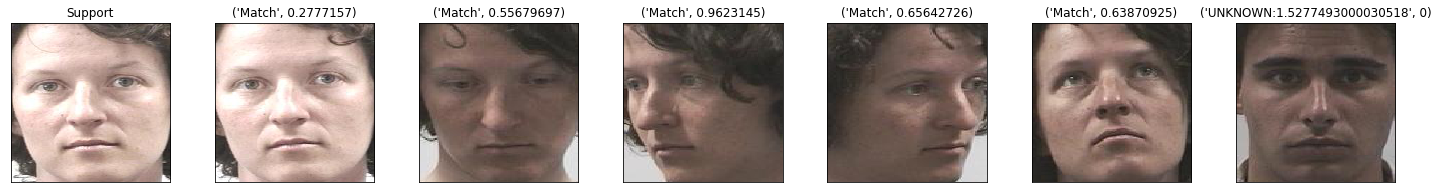

In [38]:
orientation_detection("orientation/faces-ori",
                         detector = 'mtcnn', threshold = 1)

In [39]:
def recognize2(img,known_faces_encoding,known_faces_id,threshold = 0.75):

  scores = np.zeros((len(known_faces_id),1),dtype=float)

  enc = enc_model.predict(img.reshape(1,160,160,3))
  enc/= np.sqrt(np.sum(enc**2))

  scores = np.sqrt(np.sum((enc-known_faces_encoding)**2,axis=1))

  match = np.argmin(scores)

  if scores[match] > threshold :

    return 0
      
  else :

    return 1

In [41]:
def orientation_detection_eval(file_path,
                         detector = 'mtcnn', threshold = 0.75):
  face_cascade = cv2.CascadeClassifier('Models/haarcascade_frontalface_default.xml')
  perc = 0
  snd = 0
  for name in os.listdir(file_path):
    # Read each test image
    image_path=os.path.join(file_path,name)
    folder_path=os.path.join("orientation/all","P0"+name.split('.')[0])
    #img = detect_face(image_path,normalize = False)
    #get encoding of support faces first
    
    known_faces_encoding = []
    known_faces_id = []

    known_faces_path = image_path

    
    if '.ipynb' not in name:
      # Detect faces
      face = detect_face(known_faces_path,normalize = True)
      face1 = detect_face(known_faces_path,normalize = False)
      # Compute face encodings

      feature_vector = enc_model.predict(face.reshape(1,160,160,3))
      feature_vector/= np.sqrt(np.sum(feature_vector**2))
      known_faces_encoding.append(feature_vector)

      # Save Person IDs
      label = name.split('.')[0]
      known_faces_id.append(label)


    known_faces_encoding = np.array(known_faces_encoding).reshape(len(known_faces_encoding),128)
    known_faces_id = np.array(known_faces_id)
    files = os.listdir(folder_path)
    c = 0
    nd = 0
    for pic in files:
      pic_path=os.path.join(folder_path,pic)
      try:
        face_array = detect_face(pic_path,normalize = False)
      except IndexError:
        nd = nd+1
        #img1 = cv2.imread(pic_path)
        #cv2_imshow(img1)
      else:
        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized = (face_array - mean) / std

        # Recognize
        label = recognize2(face_array_normalized,known_faces_encoding,known_faces_id,threshold)
            
        #cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 2)
        #cv2.putText(img, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
        c = c + label
        #print(label)
        # Display
        #cv2_imshow(img)
    perc = perc + c*100/186
    snd = snd + nd
    print("Accuracy: ",c*100/186," and Not Detected = ",nd)
  print("Average Accuracy: ",perc/5," and Total Not Detected = ",snd)

In [42]:
orientation_detection_eval("orientation/faces",
                         detector = 'mtcnn', threshold = 1)

Accuracy:  82.79569892473118  and Not Detected =  2
Accuracy:  90.86021505376344  and Not Detected =  1
Accuracy:  76.88172043010752  and Not Detected =  7
Accuracy:  88.17204301075269  and Not Detected =  1
Accuracy:  80.64516129032258  and Not Detected =  2
Average Accuracy:  83.87096774193547  and Total Not Detected =  13


In [44]:
known_faces_encodings_us_1 = []
known_faces_ids_us_1 = []

known_faces_path_us_1 = "us/1/"

for filename in os.listdir(known_faces_path_us_1):
  if '.ipynb' not in filename:
    # Detect faces
    face = detect_face(known_faces_path_us_1+filename,normalize = True)

    # Compute face encodings

    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings_us_1.append(feature_vector)

    # Save Person IDs
    label = filename.split('.')[0]
    known_faces_ids_us_1.append(label)


known_faces_encodings_us_1 = np.array(known_faces_encodings_us_1).reshape(len(known_faces_encodings_us_1),128)
known_faces_ids_us_1 = np.array(known_faces_ids_us_1)
#----------------------------------------------------------------------------------------------------------------------
known_faces_encodings_us_2 = []
known_faces_ids_us_2 = []

known_faces_path_us_2 = "us/2/"

for filename in os.listdir(known_faces_path_us_2):
  if '.ipynb' not in filename:
    # Detect faces
    face = detect_face(known_faces_path_us_2+filename,normalize = True)

    # Compute face encodings

    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings_us_2.append(feature_vector)

    # Save Person IDs
    label = filename.split('.')[0]
    known_faces_ids_us_2.append(label)


known_faces_encodings_us_2 = np.array(known_faces_encodings_us_2).reshape(len(known_faces_encodings_us_2),128)
known_faces_ids_us_2 = np.array(known_faces_ids_us_2)
#-----------------------------------------------------------------------------------------------------------------------
known_faces_encodings_us_3 = []
known_faces_ids_us_3 = []

known_faces_path_us_3 = "us/3/"

for filename in os.listdir(known_faces_path_us_3):
  if '.ipynb' not in filename:
    # Detect faces
    face = detect_face(known_faces_path_us_3+filename,normalize = True)

    # Compute face encodings

    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings_us_3.append(feature_vector)

    # Save Person IDs
    label = filename.split('.')[0]
    known_faces_ids_us_3.append(label)


known_faces_encodings_us_3 = np.array(known_faces_encodings_us_3).reshape(len(known_faces_encodings_us_3),128)
known_faces_ids_us_3 = np.array(known_faces_ids_us_3)
#---------------------------------------------------------------------------------------------------------------
known_faces_encodings_us_4 = []
known_faces_ids_us_4 = []

known_faces_path_us_4 = "us/4/"

for filename in os.listdir(known_faces_path_us_4):
  if '.ipynb' not in filename:
    # Detect faces
    face = detect_face(known_faces_path_us_4+filename,normalize = True)

    # Compute face encodings

    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings_us_4.append(feature_vector)

    # Save Person IDs
    label = filename.split('.')[0]
    known_faces_ids_us_4.append(label)


known_faces_encodings_us_4 = np.array(known_faces_encodings_us_4).reshape(len(known_faces_encodings_us_4),128)
known_faces_ids_us_4 = np.array(known_faces_ids_us_4)

In [61]:
def face_recognition_us(mode,file_path,detector = 'haar', threshold = 0.75):


  if mode == 'webcam':

    # To capture webcam feed. Change argument for differnt webcams
    cap = cv2.VideoCapture(0)

  elif mode == 'video':
    # To capture video feed 
    cap = cv2.VideoCapture('us_test/us_test.mp4')
    #cap = open('/content/drive/MyDrive/Inception_Face_Recognition_using_Siamese_Network-master/test.mp4','rb').read()
  c = 0
  Register = {
  "Karthik": "Absent",
  "Dhanush": "Absent",
  "Bhargav": "Absent",
  "Nithin": "Absent"
    }   
  while True:
    # Read the frame
    _, img = cap.read()
    
    # Stop if end of video file
    if _ == False:
        print('false')
        break;
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    topLeft = img[0:cY, 0:cX]
    topRight = img[0:cY, cX:w]
    bottomLeft = img[cY:h, 0:cX]
    bottomRight = img[cY:h, cX:w]
    # if face is not detected, then continue
    results_topLeft = mtcnn_detector.detect_faces(topLeft)
    if(len(results_topLeft)!=0):
      face_topLeft = []
      face_topLeft.append(results_topLeft[0]['box'])
      for (x, y, w, h) in face_topLeft:
        
        image = Image.fromarray(topLeft[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized_us_1 = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized_us_1,known_faces_encodings_us_1,known_faces_ids_us_1,threshold)
        if c%5==0:
          if "UNKNOWN" not in label[0]:
            Register["Karthik"] = "Present"
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    results_topRight = mtcnn_detector.detect_faces(topRight)
    if(len(results_topRight)!=0):
      face_topRight = []
      face_topRight.append(results_topRight[0]['box'])
      for (x, y, w, h) in face_topRight:
        
        image = Image.fromarray(topRight[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized_us_2 = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized_us_2,known_faces_encodings_us_2,known_faces_ids_us_2,threshold)
        if c%5==0:
          if "UNKNOWN" not in label[0]:
            Register['Dhanush'] = "Present"
        cv2.rectangle(img, (cX+x, y), (cX+x+w, y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (cX+x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    results_bottomLeft = mtcnn_detector.detect_faces(bottomLeft)
    if(len(results_bottomLeft)!=0):
      face_bottomLeft = []
      face_bottomLeft.append(results_bottomLeft[0]['box'])
      for (x, y, w, h) in face_bottomLeft:
        
        image = Image.fromarray(bottomLeft[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized_us_3 = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized_us_3,known_faces_encodings_us_3,known_faces_ids_us_3,threshold)
        if c%5==0:
          if "UNKNOWN" not in label[0]:
            Register["Bhargav"] = "Present"
        cv2.rectangle(img, (x, cY+y), (x+w, cY+y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (x, cY+y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    results_bottomRight = mtcnn_detector.detect_faces(bottomRight)
    if(len(results_bottomRight)!=0):
      face_bottomRight = []
      face_bottomRight.append(results_bottomRight[0]['box'])
      for (x, y, w, h) in face_bottomRight:
        
        image = Image.fromarray(bottomRight[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)

        # Normalize
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized_us_4 = (face_array - mean) / std

        # Recognize
        label = recognize(face_array_normalized_us_4,known_faces_encodings_us_4,known_faces_ids_us_4,threshold)
        if c%5==0:
          if "UNKNOWN:" not in label[0]:
            Register["Nithin"] = "Present"
        cv2.rectangle(img, (cX+x, cY+y), (cX+x+w, cY+y+h), (0, 0, 0), 2)
        cv2.putText(img, label[0], (cX+x, cY+y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    c = c + 1
    # Display
    if c%5==0:
      plt.axis("off")
      plt.figure(figsize = (30,20))
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()
    if c==20:
      print(Register)
      break
    # Stop if escape key is pressed
    key = cv2.waitKey(25) & 0xff
    if key==27:
        break

  # Release the VideoCapture object
  cap.release() 
cv2.destroyAllWindows()

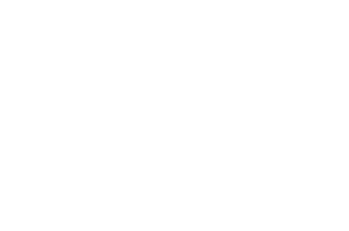

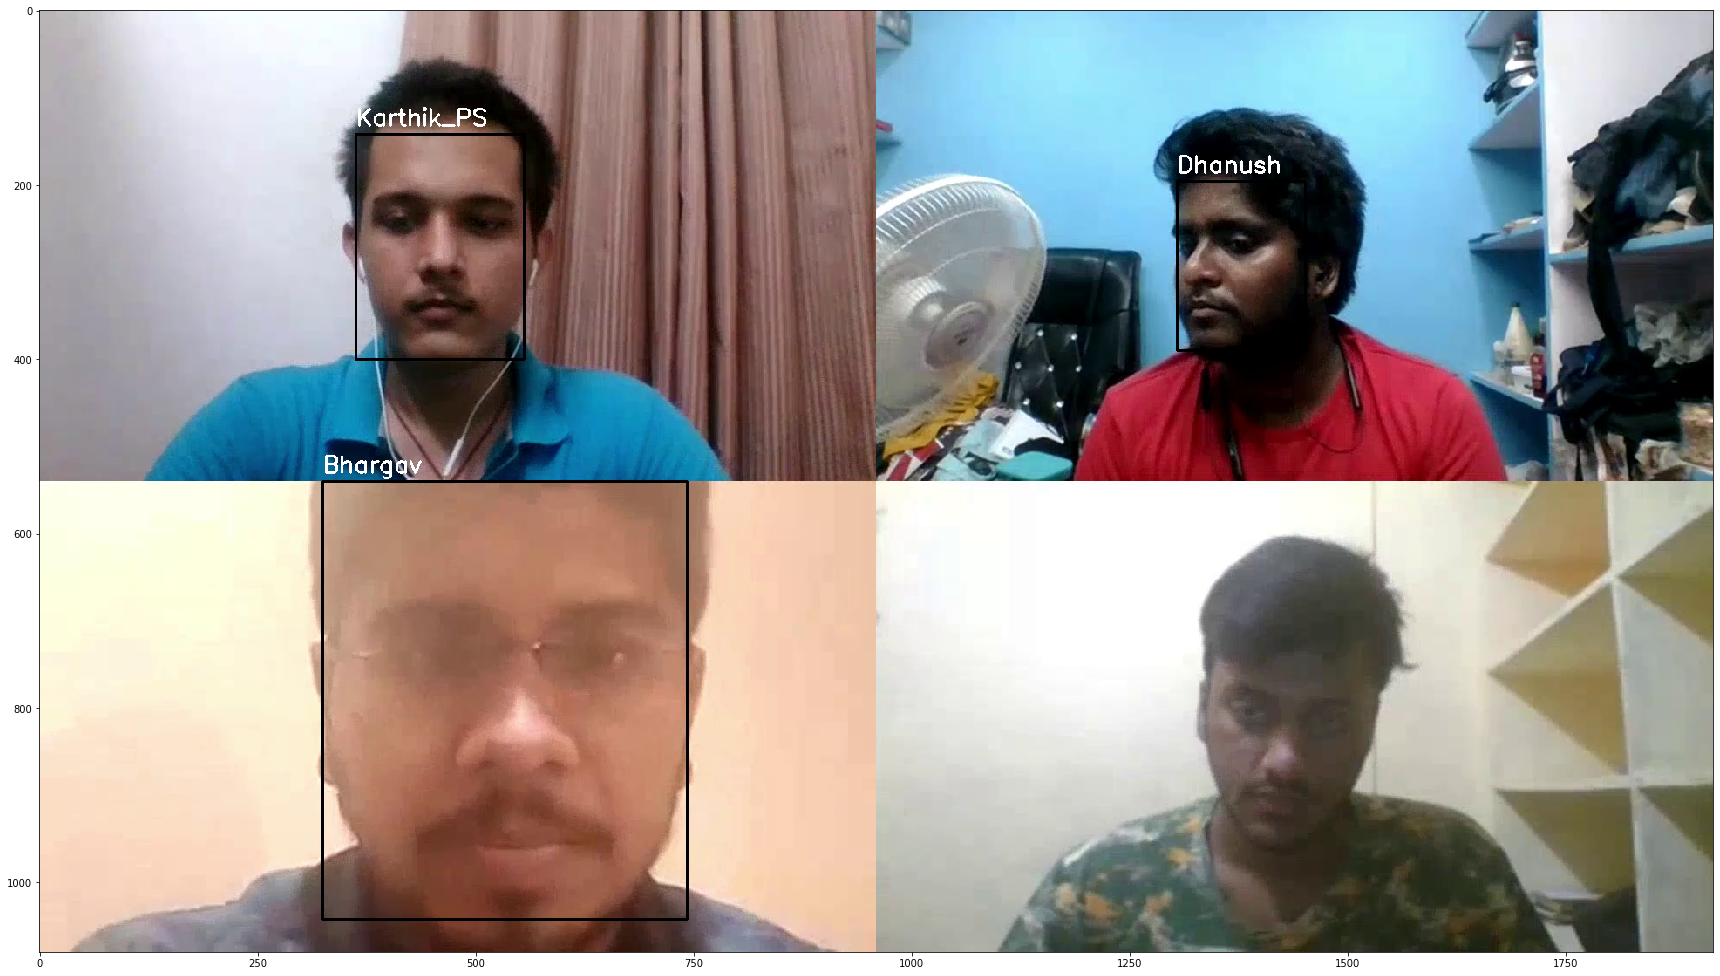

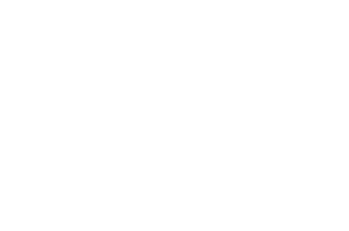

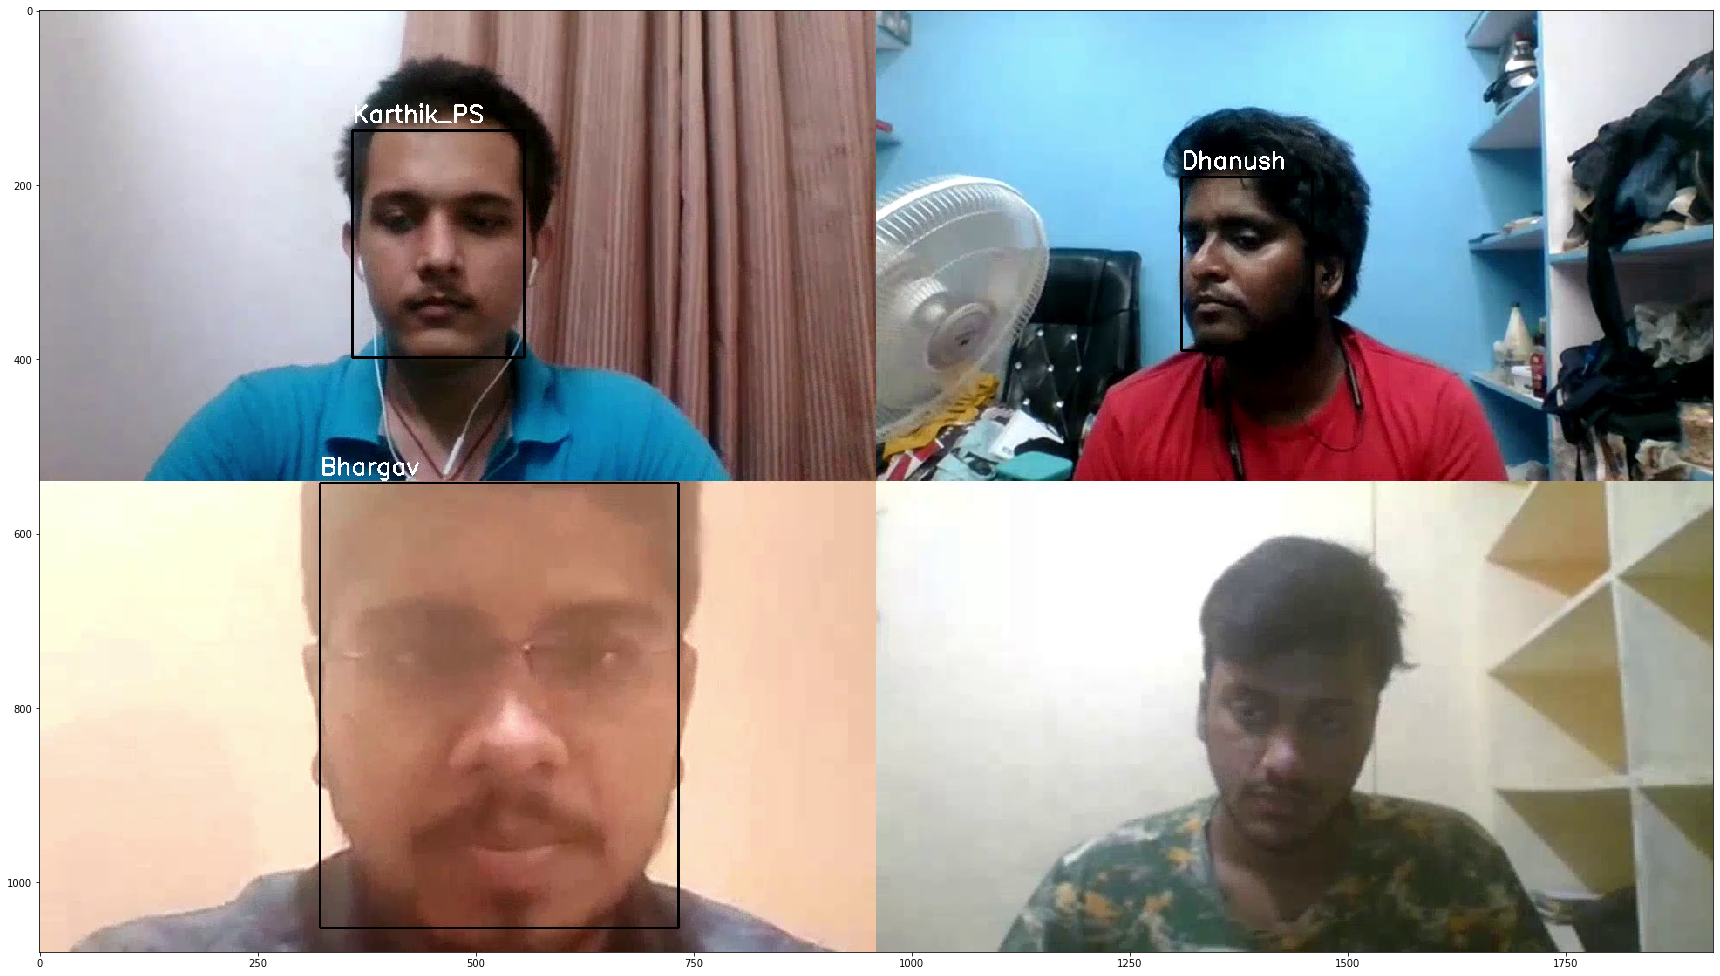

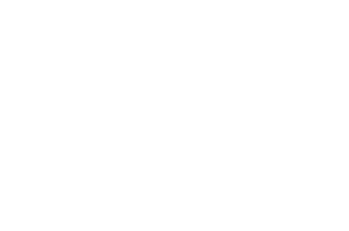

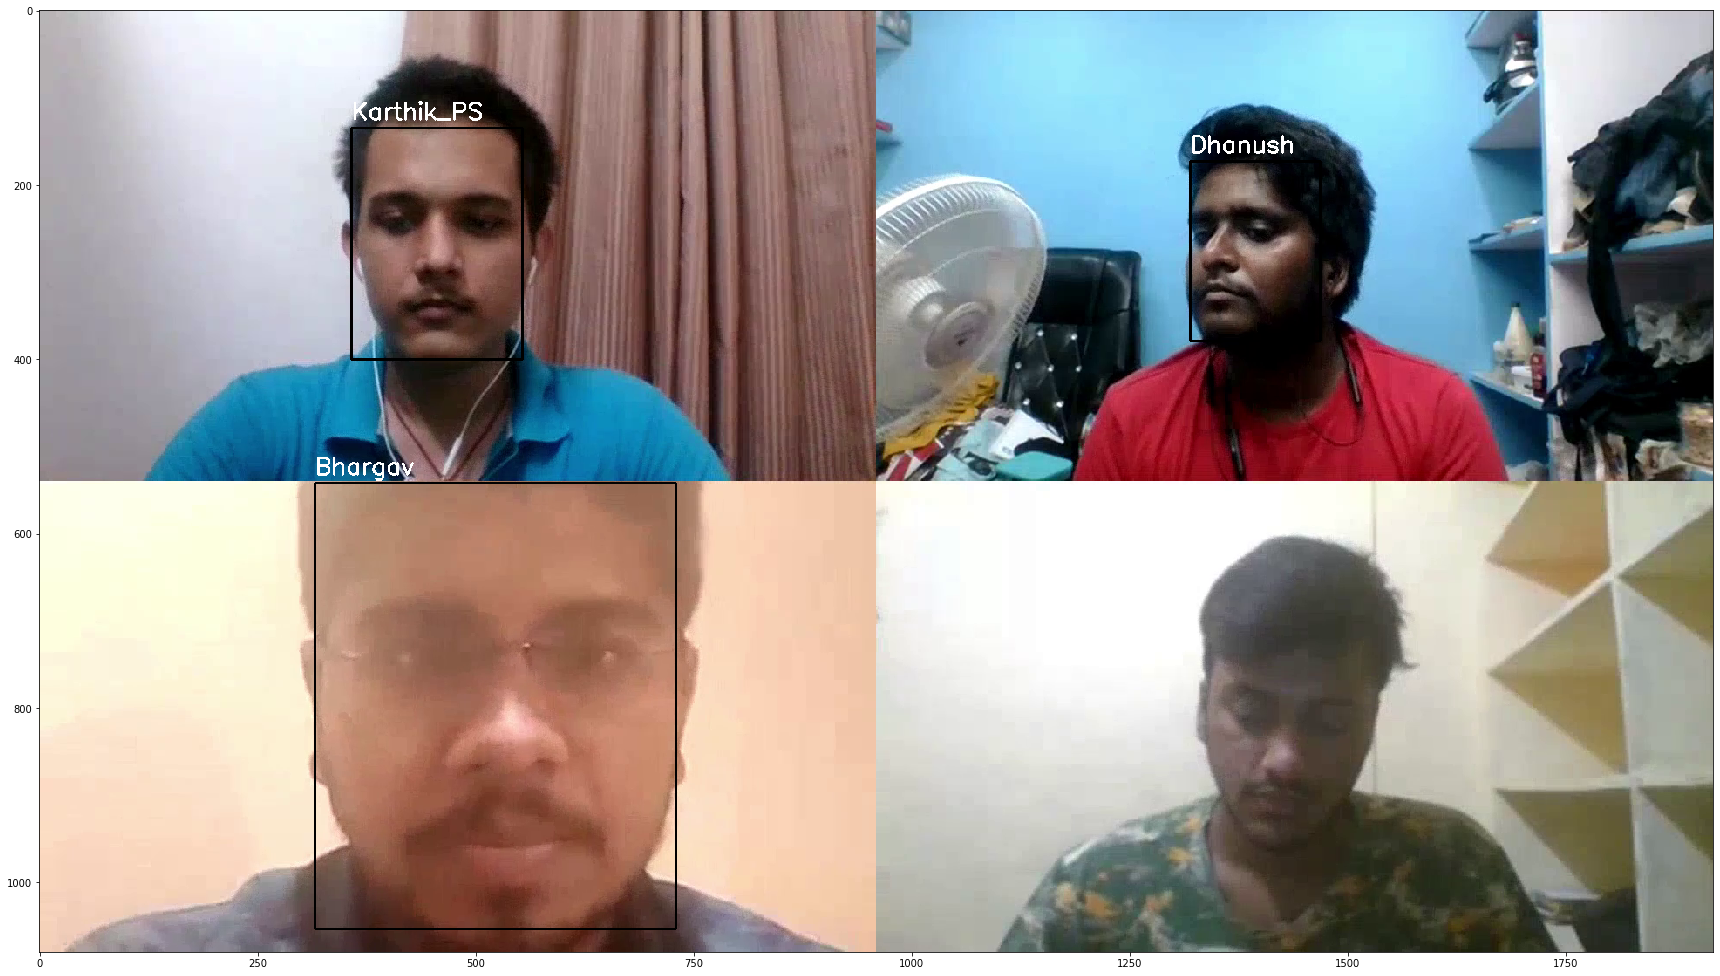

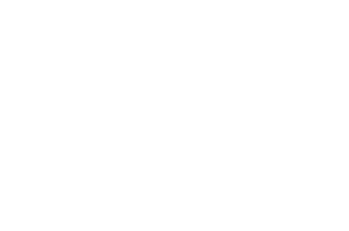

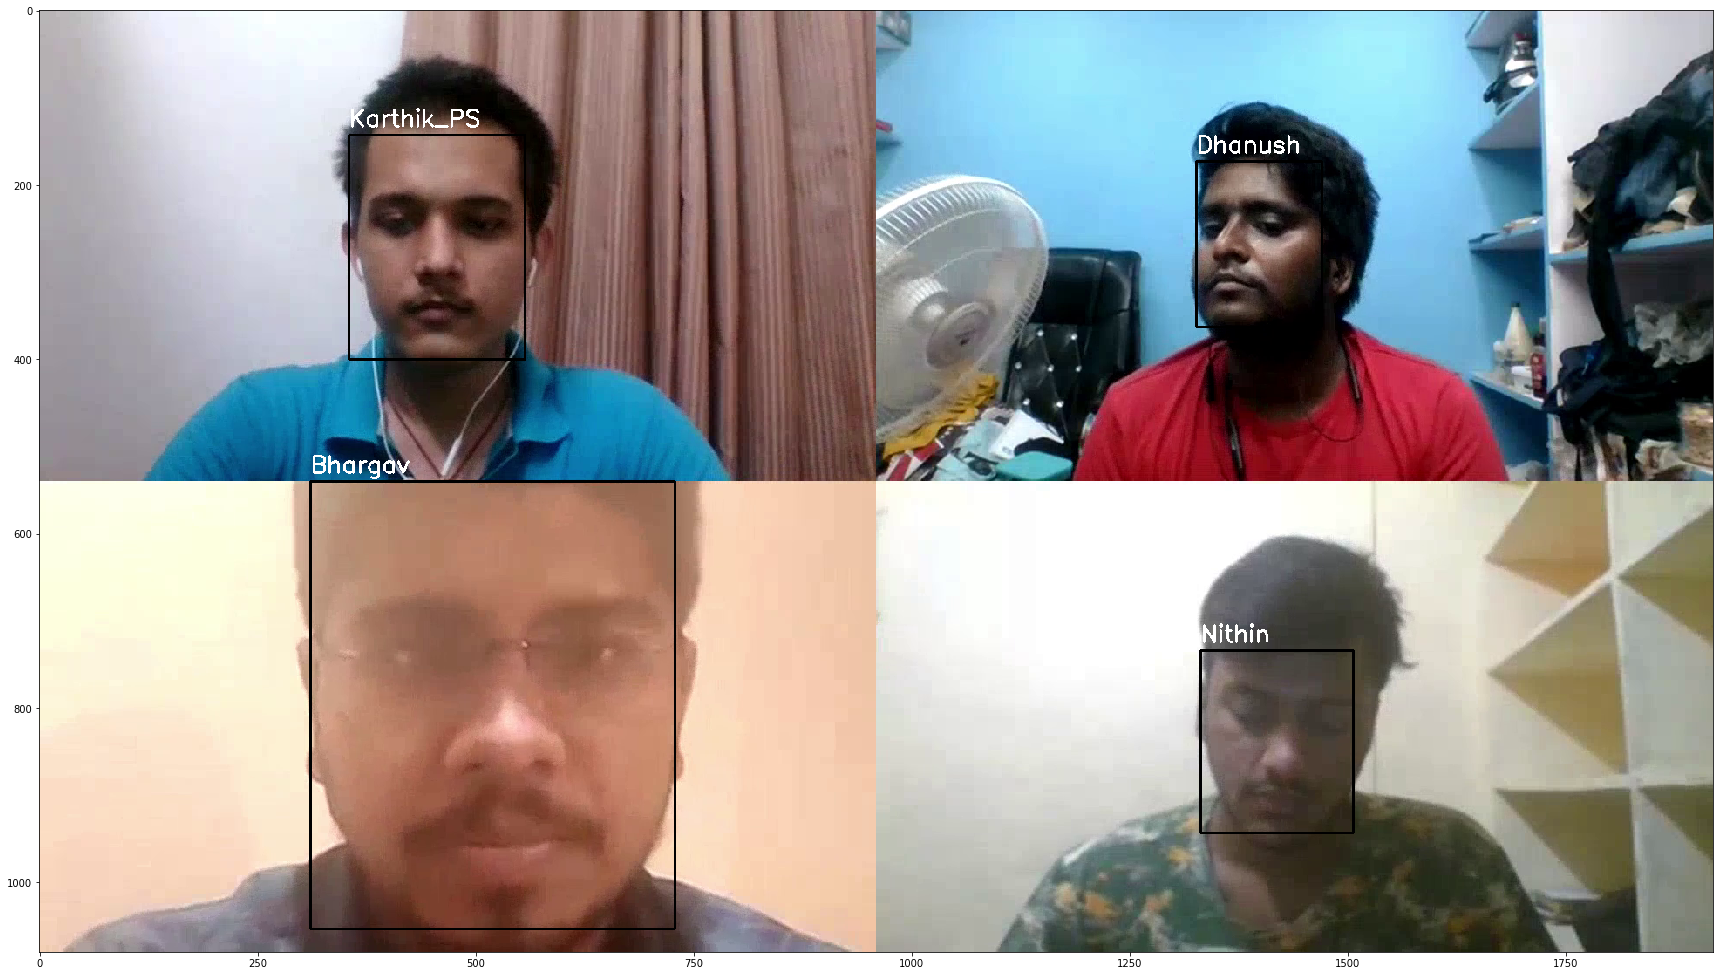

{'Karthik': 'Present', 'Dhanush': 'Present', 'Bhargav': 'Present', 'Nithin': 'Present'}


In [62]:
face_recognition_us('video',"/us_test.mp4",detector = 'mtcnn',threshold = 1.2)